In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import deque

import evoenv
from evoenv.matrixtools import FloatTupleDtype
from evoenv.envs.enumerated_stochastic_game import MatrixGame

### General Utils

In [2]:
def get_full_state(state, prev_states, col_idx, action_space):
    """
    Description: This method creates a complete state by combining
    a state observation with all player actions.  We standardize to make sure
    the actions are all ordered so action vector 1 is the player and action vector 2 - N
    are the opponents
    """

    # only move the columns if they're not already in first position
    if col_idx != 1:
      # cols to move
      columns_to_move = [x for x in range(col_idx, col_idx + action_space)]

      # Define the new position for the selected columns
      new_position = 1

      # Move the selected columns to the new position
      prev_states = np.hstack((prev_states[:, :new_position],
                               prev_states[:, columns_to_move],
                               prev_states[:, new_position:new_position + len(columns_to_move)]))

    # state full concatonates the current state with the previous memory of states/actions
    state_full = np.concatenate([np.array(state).flatten(), prev_states.flatten()])
    return state_full


def make_one_hot_dict(num_actions = 4):
    """
    Description: This method returns a dictionary of one hot encodings
    """
    one_hot_dict = {}
    for x in range(0, num_actions):
        one_hot_dict[x] = [0 for y in range(0, num_actions)]
        one_hot_dict[x][x] = 1
    return one_hot_dict


def convert_state(state):
    """
    Description: Checks the type of state and converts it to a flattened numpy
    numpy array
    """
    if isinstance(state, tuple):
        state = state[0].flatten()
    else:
        state = np.array([state])
    return state


def get_init_state_dist(players):
    states = [[0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 1, 0],
          [0, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0],
          [0, 0, 0, 1, 0, 1]]
    
    df = pd.DataFrame()
    for player in players:
        tmp = {}
        
        for state in states:
            _, _, output, _ = player.policy(torch.tensor(state, dtype=torch.float))
            tmp[''.join(str(state))] = output.detach().numpy()[0]
            tmp = pd.DataFrame(tmp, index=[0])

        tmp['player_id'] = player.player_id
        df = pd.concat([df, tmp])
    return df


def plot_init_state_dist(df):
    states = [[0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 1, 0],
          [0, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0],
          [0, 0, 0, 1, 0, 1]]
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharey=True)
    for idx, state in enumerate(states):

        axs[idx // 2, idx % 2].hist(df[str(state)],bins=20, density=False)
        axs[idx // 2, idx % 2].set_title(f'state: {state}')
        axs[idx // 2, idx % 2].set_xlabel("Initial Cooperation Value")

        axs[idx // 2, idx % 2].grid(True)
    plt.tight_layout(pad=2.5)
    plt.suptitle(f'Init State Dist')
    plt.show()
    
    
def show_payoff_mat(payoff_matrix):
    vals = np.array([sum(x) for x in payoff_matrix.flatten()]).reshape(payoff_matrix.shape)
    annots = np.array([str(x) for x in payoff_matrix.flatten()], dtype='str').reshape(payoff_matrix.shape)
    print("Error in matplotlib for displaying annotations.  Payoff matrix is:")
    print(annots)

    sns.heatmap(vals, annot=annots, fmt='', linewidth=.5)

    plt.title('Payoff Matrix')

    plt.xticks([x + 0.5 for x in range(2)], ['C', 'D'])
    plt.yticks([x + 0.5 for x in range(2)], ['C', 'D'])

    plt.show()
    
    
def make_plots(df, N):
    means = df.groupby('round').aggregate({'total_reward': 'mean'}).reset_index()
    plt.figure(figsize=(12, 12))
    plt.plot(means['round'], means['total_reward']/2, label='total_reward')
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('Round')
    plt.ylabel('Mean Reward')
    plt.title(f'Population Size: {N}')
    plt.show()
    return 1

### Payoff matrix

In [3]:
def prisoner_dilemna_payoff(b, c):
    R = b - c
    S = -c
    T = b
    P = 0

    rewards = np.array(
      [
        [(R, R), (S, T)],
        [(T, S), (P, P)]
      ], dtype=FloatTupleDtype(2)
    )

    return rewards

### Networks

In [4]:
def identity(x):
    """Return input without any change."""
    return x


class MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64), 
                 activation=F.relu, 
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
                 initialization='uniform'):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        if initialization == 'uniform':
            self.initialization = torch.nn.init.uniform_
        elif initialization == 'normal':
            self.initialization = torch.nn.init.normal_

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)

            if initialization == 'dirichlet':
                alpha = torch.tensor([0.5 for x in range (fc.weight.shape[1])])  # concentration parameters
                dirichlet = torch.distributions.Dirichlet(alpha)
                samples = dirichlet.sample([fc.weight.shape[0],])
                fc.weight.data = samples
            else:
                self.initialization(fc.weight)

            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)

            if initialization == 'dirichlet':
                alpha = torch.tensor([0.5 for x in range (self.output_layer.weight.shape[1])])  # concentration parameters
                dirichlet = torch.distributions.Dirichlet(alpha)
                samples = dirichlet.sample([self.output_layer.weight.shape[0],])
                self.output_layer.weight.data = samples
            else:
                self.initialization(self.output_layer.weight)
        else:
            self.output_layer = identity


    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x   
        return x

class CategoricalPolicy(MLP):
    def __init__(self,
                 input_size,
                 output_size,
                 hidden_sizes=(64,),
                 activation=torch.relu,
                 initialization='uniform',
                 temperature=0.1
    ):
        super(CategoricalPolicy, self).__init__(
            input_size=input_size,
            output_size=output_size,
            hidden_sizes=hidden_sizes,
            activation=activation,
            initialization=initialization)
        self.temperature = temperature

    def forward(self, x, pi=None, use_pi=True):
        x = super(CategoricalPolicy, self).forward(x)
        pi = F.softmax(x/self.temperature, dim=-1)

        dist = torch.distributions.categorical.Categorical(pi)
        action = dist.sample()

        log_pi = dist.log_prob(action)
        return action, None, pi, log_pi


### Player Class

In [5]:
class Player():
    """
    Description:  A class to describe the player.  This class stores relavant
    player information such as:

    This class will also provide a way to update player policies.
    """
    def __init__(self,
                 obs_dim,
                   act_dim,
                   memory=1,
                   device="cpu",
                   player_id=None):

        # generate random player id if not passed
        if player_id == None:
            self.player_id = np.random.randint(0, 1000000)
        else:
            self.player_id = player_id

        self.memory = memory
        self.obs_dim = obs_dim
        self.act_dim = act_dim

        self.device = device




class VPGPlayer2(Player):
    """
    An implementation of the Vanilla Policy Gradient agent,
    with early stopping based on approximate KL.
    """

    def __init__(self,
                 base_player_params,
                 actor_model_params,
                 training_params
                 ):

        # initialize player object params
        super().__init__(**base_player_params)

        self.steps = 0

        self.buffer_size = training_params.get('buffer_size', 300)
        self.batch_size = training_params.get('batch_size', 64)
        self.policy_lr = training_params.get('policy_lr', 0.01)
        self.policy_target = training_params.get('policy_target', 0)

        # Main network
        self.policy = CategoricalPolicy(**actor_model_params).to(self.device)

        # Create optimizers
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.policy_lr)

        # Experience buffer
        self.buffer = ReplayBuffer2(self.obs_dim, self.act_dim, self.buffer_size, self.device)

    def select_action(self, obs):
        action, _, probs, log_pi = self.policy(torch.Tensor(obs).to(self.device))
        return action.detach().cpu().numpy().flatten()[0]

    def train_model(self):
        # get everything in buffer (rather than sample)
        batch = self.buffer.get_all()
        
        states = batch['obs']
        actions = batch['acts']
        rewards = batch['rews']

        total_reward = torch.sum(rewards)
        policy_target = total_reward - self.policy_target*(len(rewards))

        # get probabilities from policy net
        _, _, probs, _ = self.policy(states)

        # get probs/log probs of each action
        probs = torch.distributions.categorical.Categorical(probs)
        log_probs = probs.log_prob(actions)

        # Total reward formulation
        loss = torch.sum(-log_probs * policy_target)

        # update policy weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def add_experience(self, obs, action, reward, next_state, done):
        self.buffer.add(obs, action, reward)
        return 1

    def save_network(self):
        torch.save(self.policy.state_dict(),
                   f'{self.save_path}/{self.color}/{self.population}/VPG_Player_{self.player_id}_PN_SD.csv')
        return 1

    def save_policy(self, df2, cols=['A1', 'A2', 'A3', 'A4']):
        df = df2.copy()
        df[cols] = df.apply(lambda row: self.policy(torch.Tensor(row))[2].detach().numpy(), axis=1,
                            result_type='expand')
        df[cols] = np.exp(df[cols])
        df[cols] = df[cols] / np.sum(df[cols], axis=0)
        df.to_csv(f'{self.save_path}/{self.color}/{self.population}/VPG_Player_{self.player_id}_PN.csv')
        print("Player Info Saved")

        return 1

### Population Functions

In [6]:
def generate_population(N, base_player_params, actor_model_params, training_params):
    players = []
    for i in range(0, N):
        base_player_params['player_id'] = i
        player = VPGPlayer2(base_player_params,
                            actor_model_params,
                            training_params)
        players.append(player)
    return np.array(players)

def random_pairing(input_list):
    """"
    Description: This function will pair players randomly and ignore specific red/blue players
    """
    # Convert the list to a numpy array
    array = np.array(input_list)

    # Shuffle the array in-place
    np.random.shuffle(array)

    # Reshape the array into pairs
    pairings = array.reshape(-1, 2)

    # If the original list has an odd number of elements, the last element will be unpaired
    # You can choose to handle it separately or ignore it based on your requirements
    return np.array(pairings)[np.newaxis,:]


### Memory Buffer

In [7]:
class ReplayBuffer2(object):
    """
    A simple FIFO experience replay buffer for agents.
    """

    def __init__(self, obs_dim, act_dim, size, device):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.max_size = size
        self.device = device
        self.clear()

        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.intc)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.device = device

    def add(self, obs, act, rew):
        '''
        Description: add experiences
        '''

        self.obs_buf[self.ptr] = obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def clear(self):
        '''
        Description: reset buffer
        '''
        self.obs_buf = np.zeros([self.max_size, self.obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros(self.max_size, dtype=np.intc)
        self.rews_buf = np.zeros(self.max_size, dtype=np.float32)
        self.ptr, self.size = 0, 0

    def get(self, batch_size=64):
        '''
        Description: Get all a sample of size batch size from buffer
        '''
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs=torch.Tensor(self.obs_buf[idxs]).to(self.device),
                    acts=torch.Tensor(self.acts_buf[idxs]).to(self.device),
                    rews=torch.Tensor(self.rews_buf[idxs]).to(self.device),
                    )

    def get_all(self):
        '''
        Description: Get all observations in buffer
        '''
        return dict(obs=torch.Tensor(self.obs_buf[:self.size]).to(self.device),
                    acts=torch.Tensor(self.acts_buf[:self.size]).to(self.device),
                    rews=torch.Tensor(self.rews_buf[:self.size]).to(self.device),
                    )

### Play Game

In [8]:
def play_game(env, players, timesteps, device='cpu', debug=True):
    """
    Description:  This function will play a single game between players in array
    some starting state.  The resulting networks of the players will be updated in place.

    Inputs:
      env: The environment in which p1 and p2 compete
      players: a list of players
      timesteps: the amount of timesteps to run the game for
    Output:
      env: updated environment
      players: with modified policeis
      df: a dataframe with statistics on the game
    """
    if debug:
        print(f'Starting interaction between p1_id:{players[0].player_id}, p2_id:{players[1].player_id} with {timesteps} timesteps')

    df = pd.DataFrame()

    state, actions = env.reset()

    # convert state to numpy array
    state = convert_state(state)

    # map these actions to numeric moves
    # for grid world
    action_space = 2
    action_map = {0:"C",1: "D"}
    one_hot_dict = make_one_hot_dict(action_space)

    # state queue.  The first list in the queue corresponds to
    # the current state.  The remaining lists refer to the previous states
    # note that the previous states are of size len(actions) longer than the current active state.
    memory = players[0].memory
    prev_states = deque(maxlen=memory)
    # initialize state queue for previous states
    for i in range(memory):
        prev_states.append([0 for x in range(len(state) + len(players)*action_space)])
    prev_states = np.array(prev_states)

    # The full state is a flattened vector of the current state and (previous state, a0, a1) tuples
    # depending on the setting for memory this can be multiple
    state_full = get_full_state(state, prev_states, col_idx=len(state), action_space=len(actions))

    # do this loop until terminal state
    for i in range(timesteps):
        actions = []
        one_hot_actions = []
        full_states = []

        # select an action for each player
        for idx, player in enumerate(players):
            col_idx = len(state) + idx * action_space
            state_full = get_full_state(state, prev_states, col_idx=col_idx, action_space=action_space)
            
            # save full states so we don't need to recompute
            full_states.append(state_full)

            # from this we create the state vector for the particular player
            action = player.select_action(state_full)
            one_hot_actions.append(one_hot_dict[action])
            actions.append(action)

        observation, _, rewards, _ = env.step(tuple(actions))

        # dequeou oldest prev_state in memory and add newest one now that we have action pairs
        #prev_states.pop()
        prev_states = np.delete(prev_states, -1, axis=0)
        prev_states = np.insert(prev_states, 0, np.append(state, one_hot_actions).flatten(), axis=0)

        tmp = record_results(full_states, actions, one_hot_actions, rewards, start_timestep=i, end_timestep=i+1)
        df = pd.concat([df, tmp])

        # convert observation to flattened numpy array
        observation = convert_state(observation)

        # add experience
        for idx, player in enumerate(players):
            col_idx = len(state) + idx * action_space
            state_full = full_states[idx]
            observation_full = get_full_state(observation, prev_states, col_idx=col_idx, action_space=action_space)
            player.steps += 1

            # can be different depending on player type
            player.add_experience(state_full,
                                 actions[idx],
                                 rewards[idx],
                                 observation_full,
                                 done=False)
            
        # set state to next state
        state = observation

    if debug:
        print("Interaction Complete")
    # Train players at the end of the encounter
    for idx, player in enumerate(players):
        if debug:
            print(f'Training Player {player.player_id} on interactions of size {player.buffer.size}')

        player.train_model()
        player.buffer.clear()
        
        if debug:
            print(f"Training complete for {player.player_id}, clearing Buffer, buffer now has size {player.buffer.size}")


    return env, players, df


def play_paired_games(env, player_pairs, players, device='cpu', debug=True):
    """
    Description:  This function will play all of the games in the player_pairs
    matrix and record episodic rewards

    Inputs:
      env: environment in which players will play
      player_pair: a matrix of player ids pairings who will play agains each other
      players: a list of player objects
    Outputs:
      df: a dataframe with statistics on the game
    """

    df = pd.DataFrame()
            
    # x is a population indexer
    # y is a match pair indexer
    for x in range(player_pairs.shape[0]):
        for y in range(player_pairs.shape[1]):
            # reset environment
            state, actions = env.reset()

            # player_pairs[x, y] correspond to all the players in this particular game
            # this generalizes so if theres an array of 10 player ids stored at this
            # location, then 10 players will play in this match.

            player_pair = players[player_pairs[x, y].astype(int)]
            # play the game between these players append rewards

            prob = 1 - gamma
            timesteps = np.random.geometric(prob, size=1)[0]

            env, player_pair, tmp = play_game(env, player_pair, timesteps, device, debug)
            df = pd.concat([df, tmp])
    return df

In [9]:
def record_results(full_states, actions, one_hot_actions, rewards, start_timestep, end_timestep):
    """
    Description: Log results of the particular game between 2 players
    """
    
    mutual_cooperation_flag = 0
    mutual_defection_flag = 0
    exploit_flag = 0
    p1_exploit_flag = 0
    p2_exploit_flag = 0
    # action zero = cooperate, action 1 = defect based on payoff defined in cg_utils

    if (actions[0] == 1) & (actions[1] == 1):
        mutual_defection_flag = 1

    elif (actions[0] == 0) & (actions[1] == 0):
        mutual_cooperation_flag = 1

    # p1 exploits p2
    elif (actions[0] == 1) & (actions[1] == 0):
        p1_exploit_flag = 1
        exploit_flag = 1

    # p2 exploits p1
    else:
        p2_exploit_flag = 1
        exploit_flag = 1


    # store metrics related to the episode
    tmp = {
      'start_timestep':start_timestep,
      'end_timestep':end_timestep,
      'episode_length':end_timestep - start_timestep,
      'p1_reward':rewards[0],
      'p2_reward':rewards[1],
      'total_reward': rewards[0]+rewards[1],
      'p1_state':', '.join(map(str, full_states[0])),
      'p2_state':', '.join(map(str, full_states[1])), # adding these to see if we can optimize behavior in particular states
      'p1_action':', '.join(map(str, one_hot_actions[0])),
      'p2_action':', '.join(map(str, one_hot_actions[1])),
      'mutual_cooperation_flag':mutual_cooperation_flag,
      'mutual_defection_flag':mutual_defection_flag,
      'exploit_flag': exploit_flag,
      'p1_exploit_flag':p1_exploit_flag,
      'p2_exploit_flag':p2_exploit_flag,
      'p1_id':players[0].player_id,
      'p2_id':players[1].player_id}

    return pd.DataFrame(tmp, index=[0])
   

### Settings

#### Environment

In [10]:
input_size = 6 # state space (current state, previous state, p1 action, p2 action)
output_size = 2 # action space

# prisoners dilemna setting
b = 3
c = 1

N = 10 # population size
gamma = 0.99 # interaction length
rounds = 10 # number of interactions to play

rewards = prisoner_dilemna_payoff(b, c)
env = evoenv.envs.MatrixGame(rewards)

fix_pairings = 0 # 0 means new opponents each round, 1 means same opponenet all rounds

Error in matplotlib for displaying annotations.  Payoff matrix is:
[['(2., 2.)' '(-1., 3.)']
 ['(3., -1.)' '(0., 0.)']]


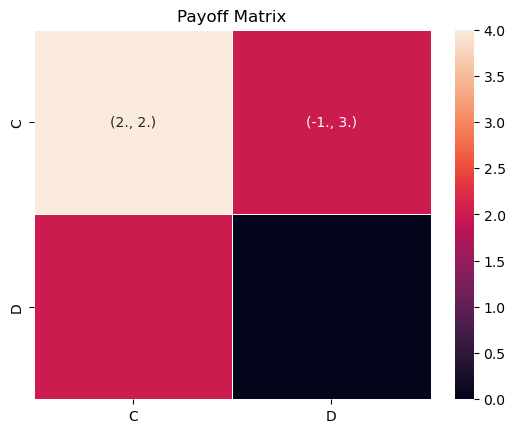

In [11]:
show_payoff_mat(rewards)

#### Player

In [12]:
########### Model Params #############
hidden_size = input_size * 4
activation = F.relu # hidden layer activation
initialization = 'uniform' # network weight initialization
temperature = 0.1 # to softmax policy

########### Training Params ###########
policy_lr = 0.01
buffer_size = 1000 # max buffer size.  Get's cleared every round in this notebook 
policy_target = 1 # policy gradient target mean reward

########### Other Params ###########
memory = 1 # player memory

#### Other Params

In [13]:
device = 'cpu'
debug = True

#### Now just formatting these params

In [14]:
actor_model_params = {'input_size':input_size,
                    'hidden_sizes':(hidden_size, ),
                    'output_size':output_size,
                    'activation':activation,
                    'initialization':initialization,
                    'temperature':temperature}

training_params = {'policy_lr':policy_lr,
                    'buffer_size':buffer_size,
                    'policy_target':policy_target}

base_player_params = {'memory':memory,
                       'obs_dim':input_size,
                       'act_dim':output_size}

### Generate Population

In [15]:
players = generate_population(N, base_player_params, actor_model_params, training_params)

In [16]:
print(f'Player id {players[0].player_id}\n')
print(f'Player Policy: {players[0].policy}\n')

print(f'Player id {players[5].player_id}\n')
print(f'Player Policy: {players[5].policy}')

Player id 0

Player Policy: CategoricalPolicy(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=24, bias=True)
  )
  (output_layer): Linear(in_features=24, out_features=2, bias=True)
)

Player id 5

Player Policy: CategoricalPolicy(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=24, bias=True)
  )
  (output_layer): Linear(in_features=24, out_features=2, bias=True)
)


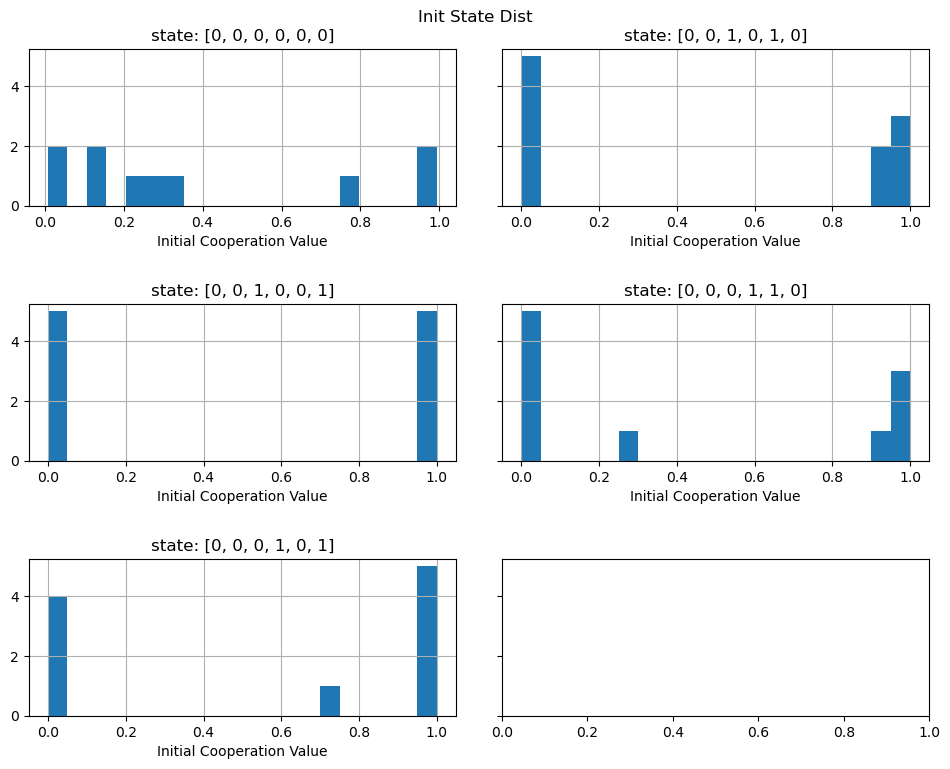

In [17]:
init_pop_dist = get_init_state_dist(players)
plot_init_state_dist(init_pop_dist)

### This is the main loop

In [18]:
# initialize output df
df = pd.DataFrame()
player_pairs = []

# initialize game, payoff, rewards, rounds, etc.
state, actions = env.reset()
policy_df = pd.DataFrame()
for round_idx in range(rounds):
    start = datetime.now()
    print(f'Round {round_idx}, Start Time {start}')

    # if are fixing pairs we only do this once
    # ie, when player pairings is first initialized
    if (fix_pairings == 0) or (len(player_pairs) == 0):
        player_pairs = random_pairing([x for x in range(N)])

    if debug:
        print("The following players will be paired this round")
        print(player_pairs)
        
    # play all the games in player_pairings and record reward
    tmp = play_paired_games(env, player_pairs, players, device, debug)

    end = datetime.now()
    total_time = end-start

    tmp['round'] = round_idx
    tmp['round_time'] = total_time

    df = pd.concat([df, tmp])

Round 0, Start Time 2024-02-08 15:50:39.324470
The following players will be paired this round
[[[5 6]
  [1 4]
  [7 0]
  [9 3]
  [8 2]]]
Starting interaction between p1_id:5, p2_id:6 with 16 timesteps
Interaction Complete
Training Player 5 on interactions of size 16
Training complete for 5, clearing Buffer, buffer now has size 0
Training Player 6 on interactions of size 16
Training complete for 6, clearing Buffer, buffer now has size 0
Starting interaction between p1_id:1, p2_id:4 with 17 timesteps
Interaction Complete
Training Player 1 on interactions of size 17
Training complete for 1, clearing Buffer, buffer now has size 0
Training Player 4 on interactions of size 17
Training complete for 4, clearing Buffer, buffer now has size 0
Starting interaction between p1_id:7, p2_id:0 with 13 timesteps
Interaction Complete
Training Player 7 on interactions of size 13
Training complete for 7, clearing Buffer, buffer now has size 0
Training Player 0 on interactions of size 13
Training complete 

Interaction Complete
Training Player 9 on interactions of size 219
Training complete for 9, clearing Buffer, buffer now has size 0
Training Player 1 on interactions of size 219
Training complete for 1, clearing Buffer, buffer now has size 0
Starting interaction between p1_id:3, p2_id:6 with 52 timesteps
Interaction Complete
Training Player 3 on interactions of size 52
Training complete for 3, clearing Buffer, buffer now has size 0
Training Player 6 on interactions of size 52
Training complete for 6, clearing Buffer, buffer now has size 0
Starting interaction between p1_id:5, p2_id:7 with 140 timesteps
Interaction Complete
Training Player 5 on interactions of size 140
Training complete for 5, clearing Buffer, buffer now has size 0
Training Player 7 on interactions of size 140
Training complete for 7, clearing Buffer, buffer now has size 0
Starting interaction between p1_id:8, p2_id:0 with 28 timesteps
Interaction Complete
Training Player 8 on interactions of size 28
Training complete fo

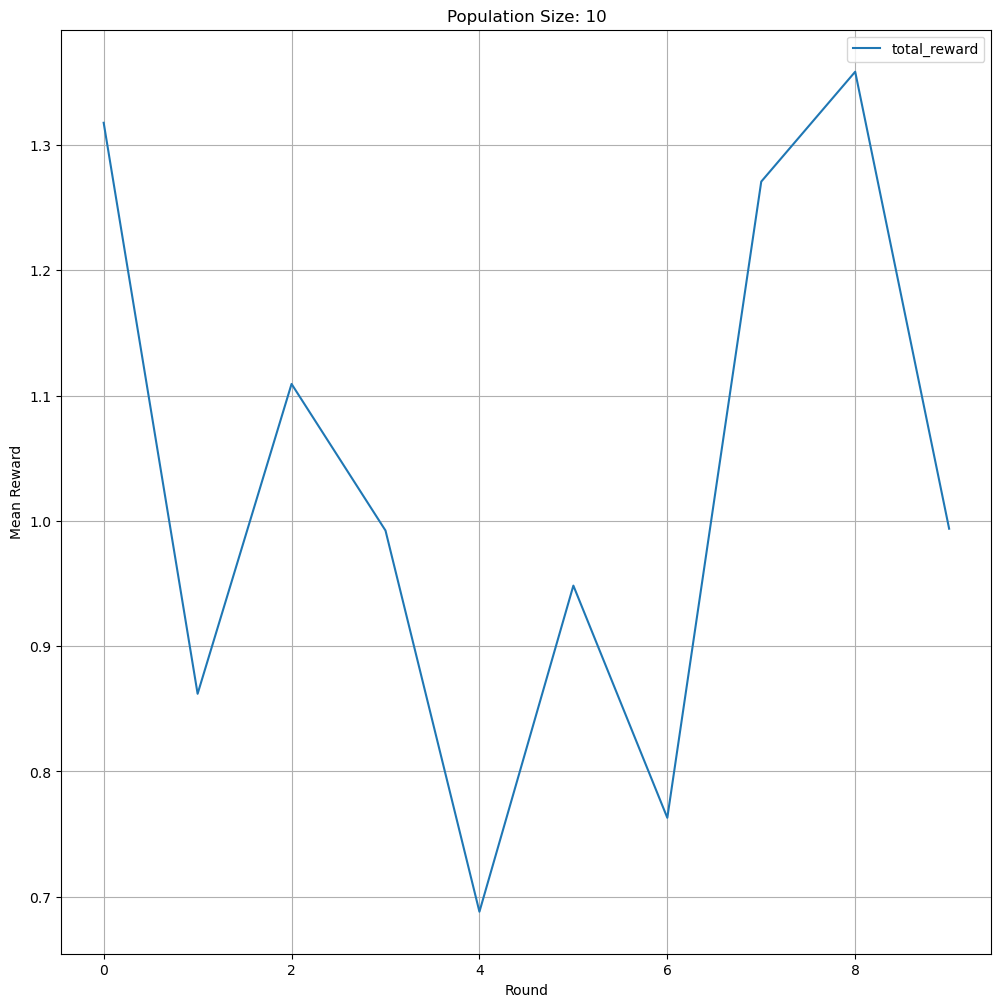

1

In [19]:
make_plots(df, N)

In [20]:
df

,start_timestep,end_timestep,episode_length,p1_reward,p2_reward,total_reward,p1_state,p2_state,p1_action,p2_action,mutual_cooperation_flag,mutual_defection_flag,exploit_flag,p1_exploit_flag,p2_exploit_flag,p1_id,p2_id,round,round_time
0,0,1,1,-1.0,3.0,2.0,"0, 0, 0, 0, 0, 0","0, 0, 0, 0, 0, 0","1, 0","0, 1",0,0,1,0,1,0,1,0,0 days 00:00:00.495031
0,1,2,1,0.0,0.0,0.0,"0, 0, 1, 0, 0, 1","0, 0, 0, 1, 1, 0","0, 1","0, 1",0,1,0,0,0,0,1,0,0 days 00:00:00.495031
0,2,3,1,-1.0,3.0,2.0,"0, 0, 0, 1, 0, 1","0, 0, 0, 1, 0, 1","1, 0","0, 1",0,0,1,0,1,0,1,0,0 days 00:00:00.495031
0,3,4,1,0.0,0.0,0.0,"0, 0, 1, 0, 0, 1","0, 0, 0, 1, 1, 0","0, 1","0, 1",0,1,0,0,0,0,1,0,0 days 00:00:00.495031
0,4,5,1,0.0,0.0,0.0,"0, 0, 0, 1, 0, 1","0, 0, 0, 1, 0, 1","0, 1","0, 1",0,1,0,0,0,0,1,0,0 days 00:00:00.495031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,121,122,1,3.0,-1.0,2.0,"0, 0, 0, 1, 1, 0","0, 0, 1, 0, 0, 1","0, 1","1, 0",0,0,1,1,0,0,1,9,0 days 00:00:00.816328
0,122,123,1,3.0,-1.0,2.0,"0, 0, 0, 1, 1, 0","0, 0, 1, 0, 0, 1","0, 1","1, 0",0,0,1,1,0,0,1,9,0 days 00:00:00.816328
0,123,124,1,3.0,-1.0,2.0,"0, 0, 0, 1, 1, 0","0, 0, 1, 0, 0, 1","0, 1","1, 0",0,0,1,1,0,0,1,9,0 days 00:00:00.816328
0,124,125,1,3.0,-1.0,2.0,"0, 0, 0, 1, 1, 0","0, 0, 1, 0, 0, 1","0, 1","1, 0",0,0,1,1,0,0,1,9,0 days 00:00:00.816328
